In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

In [2]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
dna_model = dna_client.create(colab_utils.get_api_key())

In [4]:
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

In [113]:
variant = genome.Variant(
    chromosome='chr16',
    position=19608274,
    reference_bases='T',  # Can differ from the true reference genome base.
    alternate_bases='C',
)

In [114]:
interval = variant.reference_interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

In [115]:
# The GTF file contains information on the location of all trancripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
# Mane select transcripts consists of of one curated transcript per locus.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_mane_select_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)

In [119]:
variant_output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs=[dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.SPLICE_SITES,
        dna_client.OutputType.SPLICE_SITE_USAGE,
        dna_client.OutputType.SPLICE_JUNCTIONS,],
    ontology_terms=['UBERON:0002037'],
)  # Cerebellar cortex.

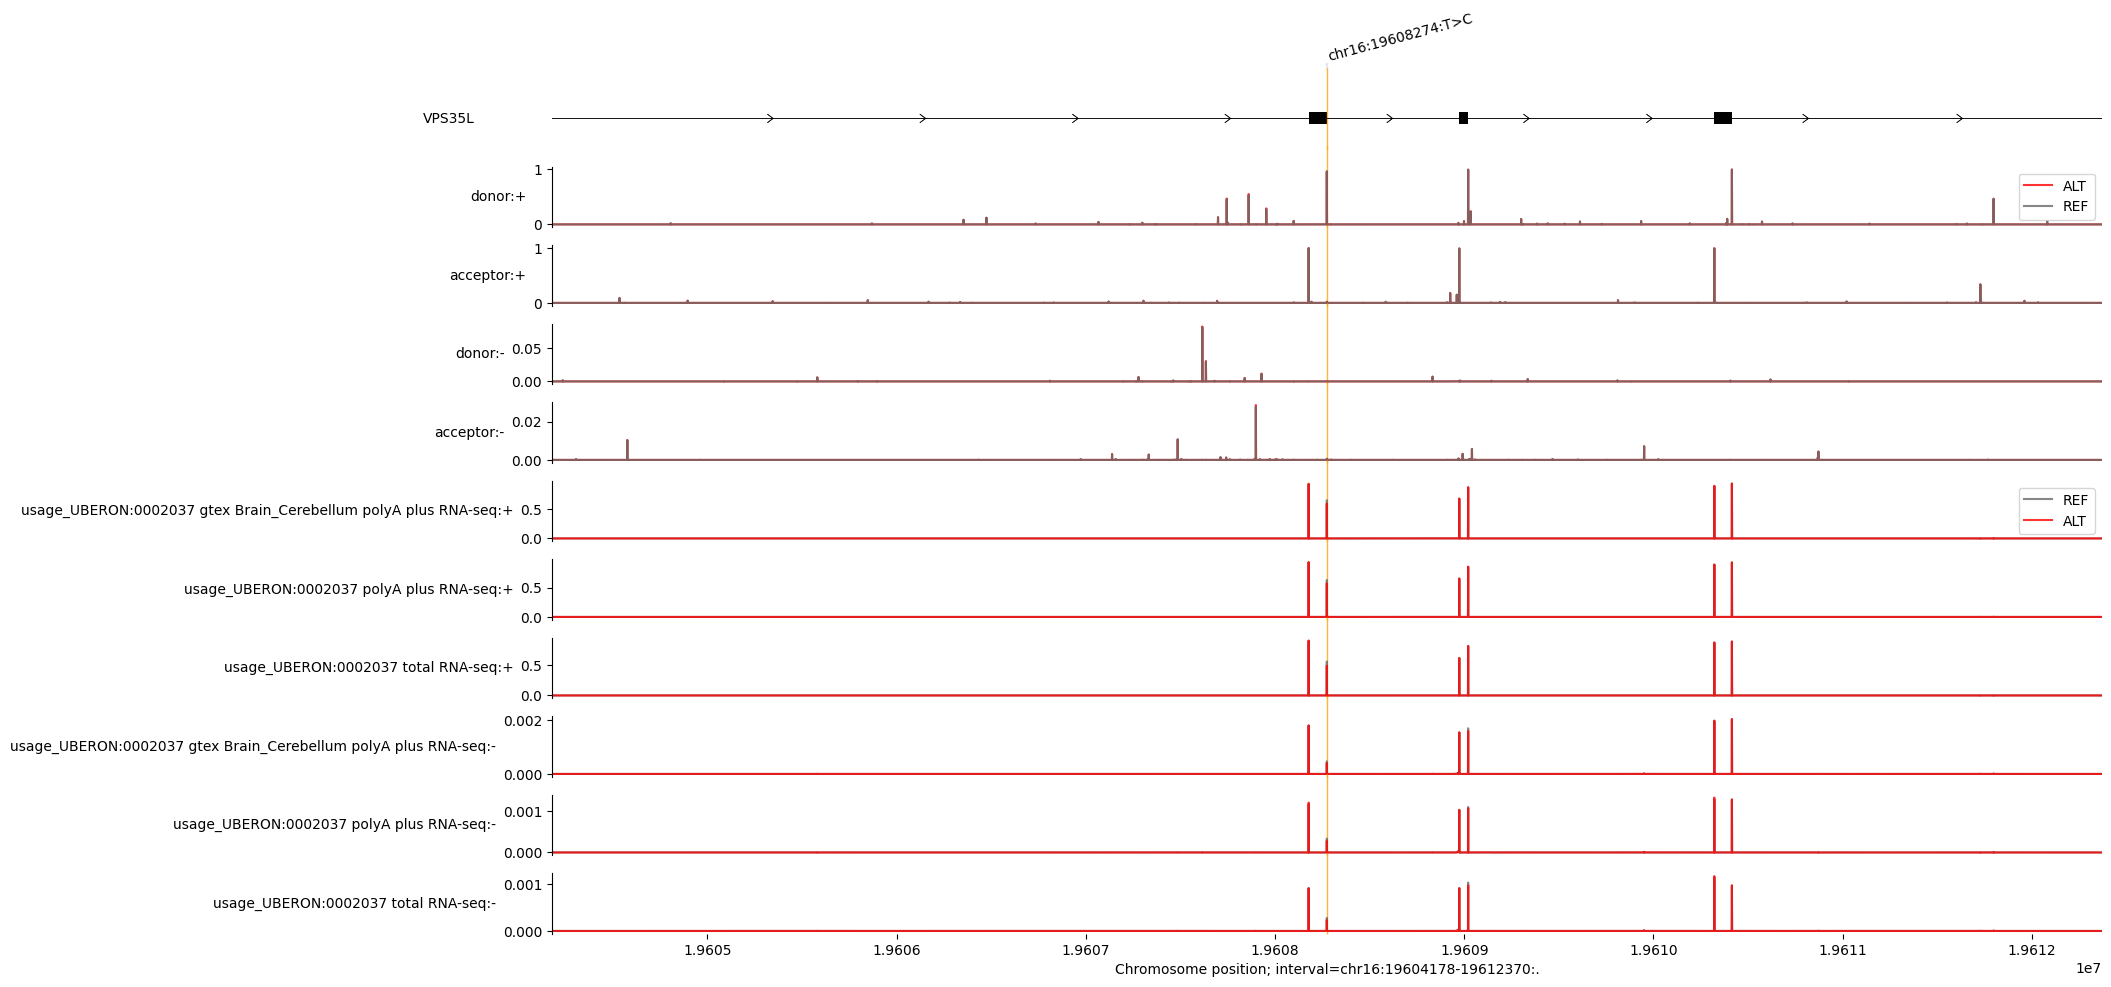

In [120]:
transcripts = transcript_extractor.extract(interval)

plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),


        # 1) SPLICE_SITES
        plot_components.OverlaidTracks(
            tdata={
                "REF": variant_output.reference.splice_sites,
                "ALT": variant_output.alternate.splice_sites,
            },
            colors={"REF": "dimgrey", "ALT": "red"},
        ),
        # 2) SPLICE_SITES_USAGE
        plot_components.OverlaidTracks(
        tdata={
            "REF": variant_output.reference.splice_site_usage,
            "ALT": variant_output.alternate.splice_site_usage,
        },
        colors={"REF": "dimgrey", "ALT": "red"},
        ),

    ],
    interval=variant_output.reference.rna_seq.interval.resize(2**13),
    # Annotate the location of the variant as a vertical line.
    annotations=[plot_components.VariantAnnotation([variant], alpha=0.8)],
)
plt.show()

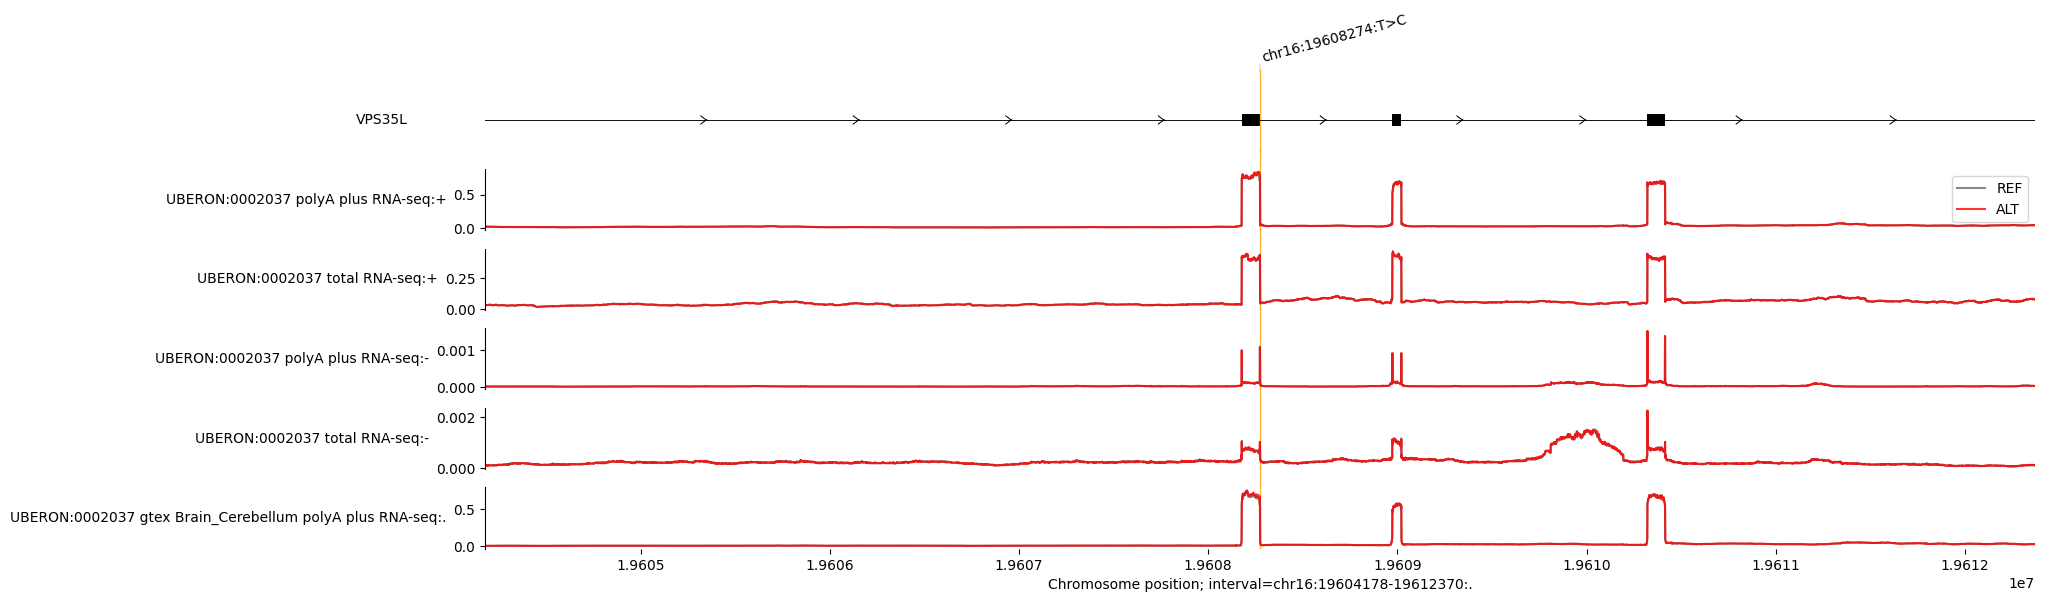

In [121]:
transcripts = transcript_extractor.extract(interval)

plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),

        # 4) RNAseq
        plot_components.OverlaidTracks(
            tdata={
                'REF': variant_output.reference.rna_seq,
                'ALT': variant_output.alternate.rna_seq,
            },
            colors={'REF': 'dimgrey', 'ALT': 'red'},
        ),

    ],
    interval=variant_output.reference.rna_seq.interval.resize(2**13),
    # Annotate the location of the variant as a vertical line.
    annotations=[plot_components.VariantAnnotation([variant], alpha=0.8)],
)
plt.show()


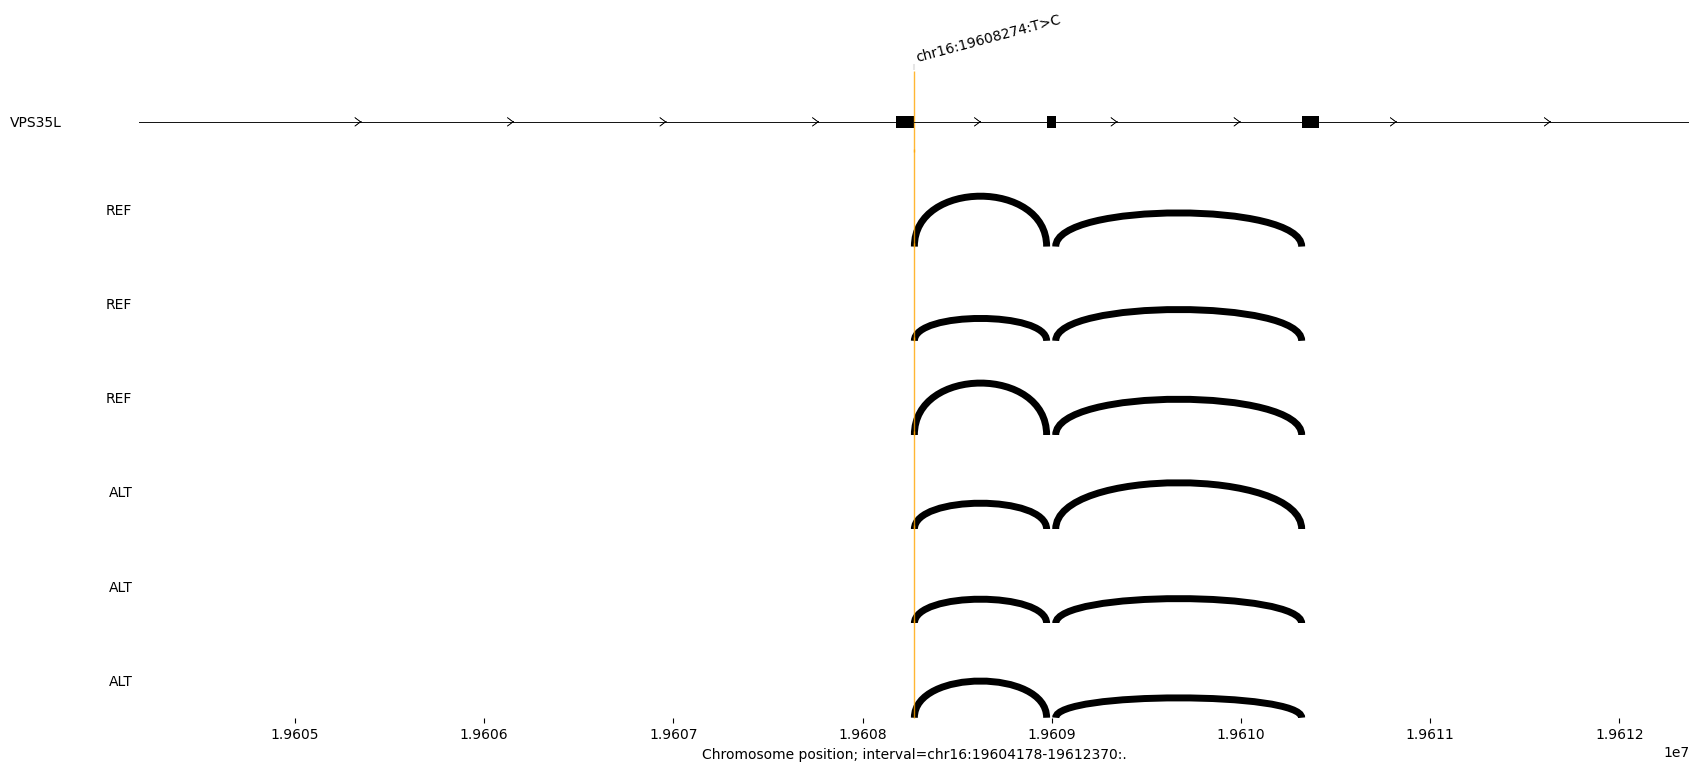

In [140]:
import matplotlib.pyplot as plt

interval_to_plot = interval.resize(2**13)
transcripts = transcript_extractor.extract(interval_to_plot)

ref_j = variant_output.reference.splice_junctions
alt_j = variant_output.alternate.splice_junctions

# strand +/- filtering
ref_j = ref_j.filter_to_positive_strand()
alt_j = alt_j.filter_to_positive_strand()
# ref_j = ref_j.filter_to_negative_strand()
# alt_j = alt_j.filter_to_negative_strand()

plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),

        plot_components.Sashimi(
            ref_j,
            fig_height=1.2,
            filter_threshold=0.05,
            ylabel_template="REF",
            annotate_counts=False,
            normalize_values=True,
            interval_contained=True,
        ),

        plot_components.Sashimi(
            alt_j,
            fig_height=1.2,
            filter_threshold=0.05,
            ylabel_template="ALT",
            annotate_counts=False,
            normalize_values=True,
            interval_contained=True,
        ),
    ],
    interval=interval_to_plot,
    annotations=[plot_components.VariantAnnotation([variant], alpha=0.8)],
)
plt.show()



In [141]:
print("REF ontology terms:", ref_j.ontology_terms)
print("ALT ontology terms:", alt_j.ontology_terms)
# The replicates in the sashimi plot are due to a replicated OntologyTerm under UBERON:0002037

REF ontology terms: [OntologyTerm(type=<OntologyType.UBERON: 2>, id=2037), OntologyTerm(type=<OntologyType.UBERON: 2>, id=2037), OntologyTerm(type=<OntologyType.UBERON: 2>, id=2037)]
ALT ontology terms: [OntologyTerm(type=<OntologyType.UBERON: 2>, id=2037), OntologyTerm(type=<OntologyType.UBERON: 2>, id=2037), OntologyTerm(type=<OntologyType.UBERON: 2>, id=2037)]
